In [1]:
%matplotlib inline
import sys
sys.path.append('../')
import numpy
import keras
from keras import backend as K

import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from wlc.WLweakener import computeM, generateWeak, weak_to_index, binarizeWeakLabels
from experiments.visualizations import plot_history
from experiments.visualizations import plot_multilabel_scatter

cmap = plt.cm.get_cmap('Accent')

random_state = 0

Using TensorFlow backend.


# Create a dataset with true labels

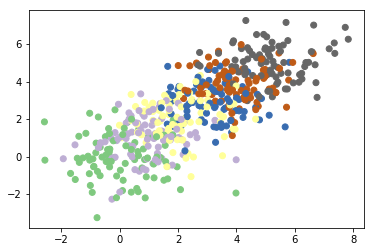

In [2]:
n_samples = 10000
n_classes = 6
X = numpy.random.randn(n_samples, 2)
y = numpy.random.randint(0, n_classes, n_samples)
X += y.reshape(-1,1)
Y = label_binarize(y, range(n_classes))
plt.scatter(X[:500,0], X[:500,1], c=y[:500], cmap=cmap)

# Generate weak labels and virtual labels

[[0.    0.    0.    0.    0.    0.   ]
 [0.023 0.023 0.023 0.023 0.023 0.124]
 [0.023 0.023 0.023 0.023 0.124 0.023]
 [0.01  0.01  0.01  0.01  0.053 0.053]
 [0.023 0.023 0.023 0.124 0.023 0.023]
 [0.01  0.01  0.01  0.053 0.01  0.053]
 [0.01  0.01  0.01  0.053 0.053 0.01 ]
 [0.004 0.004 0.004 0.023 0.023 0.023]
 [0.023 0.023 0.124 0.023 0.023 0.023]
 [0.01  0.01  0.053 0.01  0.01  0.053]
 [0.01  0.01  0.053 0.01  0.053 0.01 ]
 [0.004 0.004 0.023 0.004 0.023 0.023]
 [0.01  0.01  0.053 0.053 0.01  0.01 ]
 [0.004 0.004 0.023 0.023 0.004 0.023]
 [0.004 0.004 0.023 0.023 0.023 0.004]
 [0.002 0.002 0.01  0.01  0.01  0.01 ]
 [0.023 0.124 0.023 0.023 0.023 0.023]
 [0.01  0.053 0.01  0.01  0.01  0.053]
 [0.01  0.053 0.01  0.01  0.053 0.01 ]
 [0.004 0.023 0.004 0.004 0.023 0.023]
 [0.01  0.053 0.01  0.053 0.01  0.01 ]
 [0.004 0.023 0.004 0.023 0.004 0.023]
 [0.004 0.023 0.004 0.023 0.023 0.004]
 [0.002 0.01  0.002 0.01  0.01  0.01 ]
 [0.01  0.053 0.053 0.01  0.01  0.01 ]
 [0.004 0.023 0.023 0.004

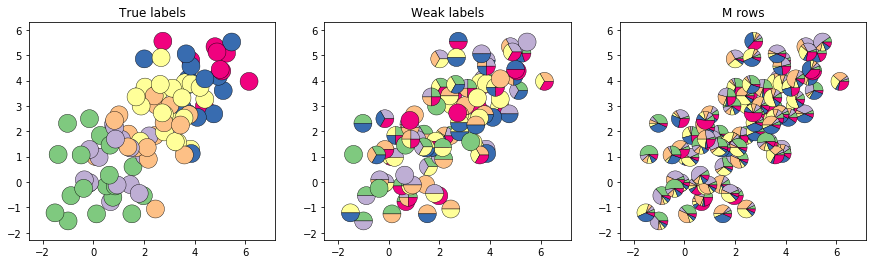

In [3]:
M_method = 'IPL'
M = computeM(n_classes, alpha=0.7, beta=0.3, method=M_method, seed=0)
if M.shape[0] == 2**M.shape[1]:
    M[0,:] = 0
    M /= M.sum(axis=0)
print(numpy.round(M, decimals=3))
z = generateWeak(y, M, seed=0)
Z = binarizeWeakLabels(z, c=n_classes)

M_indices = weak_to_index(Z, method=M_method)
V = M[M_indices]

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 3, 1)
_ = plot_multilabel_scatter(X[:100], Y[:100], fig=fig,
                            ax=ax, title='True labels', cmap=cmap)
ax = fig.add_subplot(1, 3, 2)
_ = plot_multilabel_scatter(X[:100], Z[:100], fig=fig,
                            ax=ax, title='Weak labels', cmap=cmap)
ax = fig.add_subplot(1, 3, 3)
_ = plot_multilabel_scatter(X[:100], V[:100], fig=fig,
                            ax=ax, title='M rows', cmap=cmap)

# Divide into training, validation and test

In [4]:
X_train, X_val, X_test = numpy.array_split(X, 3)
Y_train, Y_val, Y_test = numpy.array_split(Y, 3)
Z_train, Z_val, Z_test = numpy.array_split(Z, 3)
V_train, V_val, V_test = numpy.array_split(V, 3)
y_train, y_val, y_test = numpy.array_split(y, 3)

# Save the final model for each method
final_models = {}

# Define a common model

In [5]:
from keras.callbacks import EarlyStopping, Callback

max_epochs = 1000

# Callback to show performance per epoch in the same line
class EpochCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        print('\rEpoch {}, val_loss = {:.2e}, val_acc = {:.2f}'.format(epoch, logs['val_loss'], logs['val_acc']), end=' ')

# Callback for early stopping
epoch_callback = EpochCallback()
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=int(max_epochs/20), 
                               verbose=2, mode='auto', baseline=None,
                               restore_best_weights=True)

def make_model(loss):
    # Careful that it is ussing global variables for the input and output shapes
    numpy.random.seed(0)
    model = keras.models.Sequential() 
    model.add(keras.layers.Dense(Y.shape[1], input_dim=X.shape[1], activation='softmax'))
    model.compile(optimizer='adam', loss=loss, metrics=['acc', 'mse', 'ce'])
    return model

# Keyword arguments for the fit function
fit_kwargs = dict(validation_data=(X_val, Y_val), epochs=max_epochs, verbose=0,
                  callbacks=[early_stopping, epoch_callback], shuffle=True)

# Fully supervised (upperbound)

Train with all true labels

Epoch 999, val_loss = 8.79e-01, val_acc = 0.59 

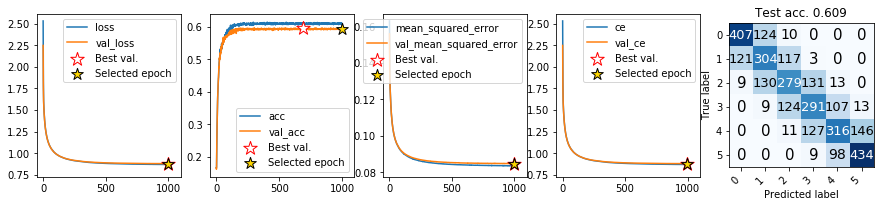

<Figure size 360x288 with 0 Axes>

In [6]:
model = make_model('categorical_crossentropy')

history = model.fit(X_train, Y_train, **fit_kwargs)
    
plot_history(history, model, X_test, y_test)

final_models['Fully supervised'] = model

# Our method with EM and original M

Train EM with all weak labels

Epoch 999, val_loss = 1.51e-01, val_acc = 0.59 

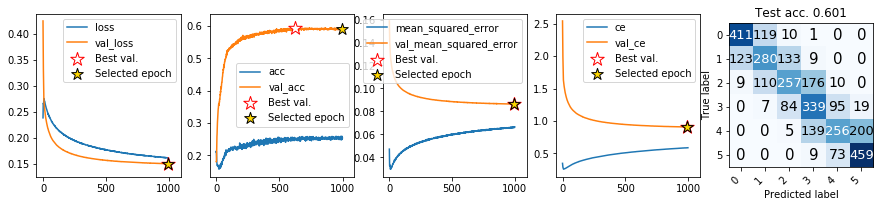

<Figure size 360x288 with 0 Axes>

In [7]:
def EM_log_loss(y_true, y_pred):
    y_pred = K.clip(y_pred, K.epsilon(), 1.0-K.epsilon())
    Q = y_true * y_pred
    Z_em_train = Q / K.sum(Q, axis=-1, keepdims=True)
    out = -K.stop_gradient(Z_em_train)*K.log(y_pred)
    return K.mean(out, axis=-1)

model = make_model(EM_log_loss)

history = model.fit(X_train, V_train, **fit_kwargs)
    
plot_history(history, model, X_test, y_test)

final_models['EM original M'] = model

# Our method with EM and estimated M

../wlc/WLweakener.py:496: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  S[weak_list, :] = alpha


Epoch 999, val_loss = 1.52e-01, val_acc = 0.59 

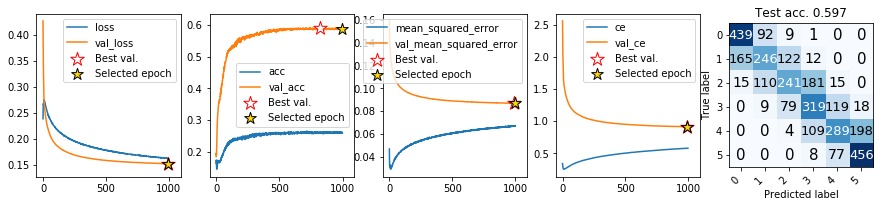

<Figure size 360x288 with 0 Axes>

In [8]:
from wlc.WLweakener import estimate_M

M_estimated = estimate_M(Z_val, Y_val, range(n_classes), reg='Partial', Z_reg=Z_train)
M_indices = weak_to_index(Z_train, method='random_weak')
V_train = M_estimated[M_indices]

model = make_model(EM_log_loss)
history = model.fit(X_train, V_train, **fit_kwargs)
    
plot_history(history, model, X_test, y_test)

final_models['EM estimated M'] = model

# Fully weak (lowerbound)

Epoch 131, val_loss = 1.65e+00, val_acc = 0.34 Restoring model weights from the end of the best epoch
Epoch 132, val_loss = 1.65e+00, val_acc = 0.35 Epoch 00133: early stopping


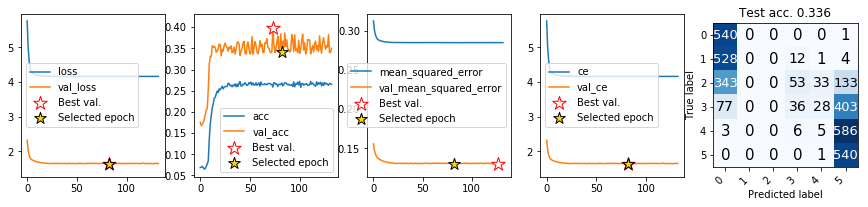

<Figure size 360x288 with 0 Axes>

In [9]:
model = make_model('categorical_crossentropy')
history = model.fit(X_train, Z_train, **fit_kwargs)

plot_history(history, model, X_test, y_test)

final_models['Fully weak'] = model

Epoch 92, val_loss = 2.48e-01, val_acc = 0.33 Restoring model weights from the end of the best epoch
Epoch 93, val_loss = 2.48e-01, val_acc = 0.33 Epoch 00094: early stopping


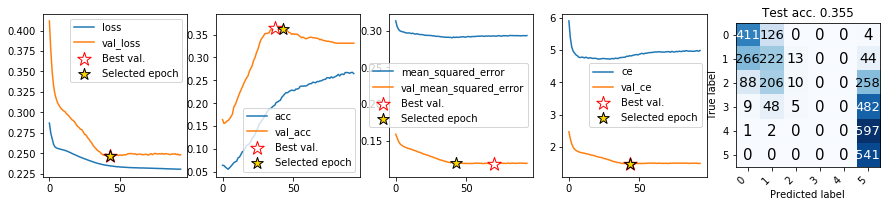

<Figure size 360x288 with 0 Axes>

In [10]:
def OSL_log_loss(y_true, y_pred):
    # Careful, I had to use a global variable here for the number of classes
    # for some reason I can not use y_osl.shape[-1] in the reshape function
    y_pred = K.clip(y_pred, K.epsilon(), 1.0-K.epsilon())
    y_osl = y_true * y_pred
    y_osl_max = K.max(y_osl, axis=-1)
    y_osl_max = K.repeat_elements(y_osl_max, n_classes, 0)
    y_osl_max = K.reshape(y_osl_max, (-1, n_classes))
    y_osl = K.cast(K.equal(y_osl, y_osl_max), y_pred.dtype)
    y_osl = y_osl / K.sum(y_osl, axis=-1, keepdims=True)
    out = -K.stop_gradient(y_osl) * K.log(y_pred)
    return K.mean(out, axis=-1)

model = make_model(OSL_log_loss)
history = model.fit(X_train, Z_train, **fit_kwargs)
    
plot_history(history, model, X_test, y_test)

final_models['OSL'] = model

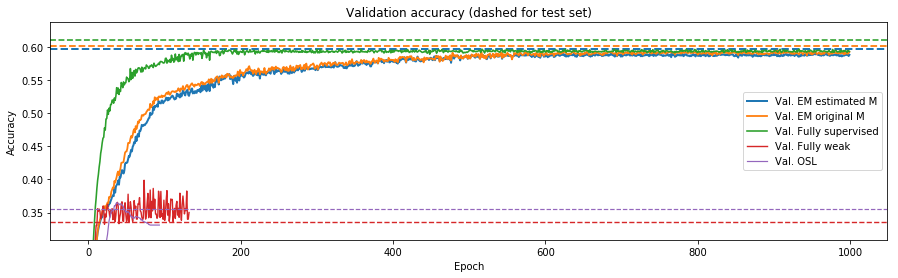

In [11]:
plt.figure(figsize=(15, 4))
lowest_acc = 1.0
highest_acc = 0.0
for i, (key, model) in enumerate(sorted(final_models.items())):
    lw = (len(final_models)+5 - i)/5
    p = plt.plot(model.history.history['val_acc'], lw=lw, label='Val. ' + key)
    test_acc = numpy.mean(model.predict_classes(X_test) == y_test)
    plt.axhline(y=test_acc, color=p[0].get_color(), lw=lw, linestyle='--')
    lowest_acc = test_acc if test_acc < lowest_acc else lowest_acc
    highest_acc = test_acc if test_acc > highest_acc else highest_acc
plt.title('Validation accuracy (dashed for test set)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
range_acc = highest_acc - lowest_acc
plt.ylim([lowest_acc-range_acc*0.1, highest_acc+range_acc*0.1])
plt.legend()